# Covid prediction XGB Confirmed Cases

### Loading libraries

In [1]:
import pandas as pd
import pandas as pd 
import random

In [2]:
import math
import time
import datetime
import operator 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-dark')
#print(plt.style.available)
%matplotlib inline

from sklearn import metrics

In [5]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [6]:
import warnings
warnings.filterwarnings("ignore")

### Preparation for predictions

#### Data Loading

In [7]:
#dataset
covid_df= pd.read_csv("corona_pred_china-2.csv")
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,01/22/2020,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,"6355,7","5,24",28800.0
1,01/22/2020,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,"337,4",0,28200.0
2,01/22/2020,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,"16183,0","4,86",19400.0
3,01/22/2020,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,"496,0",0,17800.0
4,01/22/2020,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,"640,3",0,23400.0


#### Data transformations

In [8]:
#Converting "Observation Date" into Datetime format
covid_df["ObservationDate"]=pd.to_datetime(covid_df["ObservationDate"])
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             10022 non-null  datetime64[ns]
 1   Country                     10022 non-null  object        
 2   Continent                   10022 non-null  object        
 3   Confirmed                   10022 non-null  float64       
 4   Deaths                      10022 non-null  float64       
 5   Recovered                   10022 non-null  float64       
 6   Active Cases                10022 non-null  float64       
 7   Population                  10022 non-null  float64       
 8   Area (sq. mi.)              10022 non-null  float64       
 9   Pop. Density (per sq. mi.)  10022 non-null  object        
 10  Net migration               10022 non-null  object        
 11  GDP ($ per capita)          10022 non-null  float64   

In [9]:
# Changing datatype of Population density and Net Migration columns as float
cols=["Pop. Density (per sq. mi.)","Net migration"]                             
for i in cols:
    covid_df[i]=covid_df[i].str.replace(",","").astype(float)
covid_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             10022 non-null  datetime64[ns]
 1   Country                     10022 non-null  object        
 2   Continent                   10022 non-null  object        
 3   Confirmed                   10022 non-null  float64       
 4   Deaths                      10022 non-null  float64       
 5   Recovered                   10022 non-null  float64       
 6   Active Cases                10022 non-null  float64       
 7   Population                  10022 non-null  float64       
 8   Area (sq. mi.)              10022 non-null  float64       
 9   Pop. Density (per sq. mi.)  10022 non-null  float64       
 10  Net migration               10022 non-null  float64       
 11  GDP ($ per capita)          10022 non-null  float64   

In [10]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,63557.0,524.0,28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,3374.0,0.0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,161830.0,486.0,19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,4960.0,0.0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,6403.0,0.0,23400.0


In [11]:
# Sorting based on the country names
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

In [12]:
covid_df.shape

(10022, 12)

#dataset
covid_latest_df= pd.read_csv("covid_19_latest_data.csv")
del covid_latest_df["SNo"]
del covid_latest_df["Province/State"]
covid_latest_df["ObservationDate"]=pd.to_datetime(covid_latest_df["ObservationDate"])

covid_df_kaggle_Italy = covid_latest_df[covid_latest_df["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_Italy["Continent"] = "Europe"
#covid_df_kaggle_Italy= covid_df_kaggle_Italy[covid_df_kaggle_Italy['ObservationDate'] > '2020-03-22'].reset_index(drop=True)
covid_df_kaggle_Italy["Active Cases"] = covid_df_kaggle_Italy["Confirmed"] - covid_df_kaggle_Italy["Recovered"] - covid_df_kaggle_Italy["Deaths"]
covid_df_kaggle_Italy.head()

covid_df_kaggle_Italy= covid_df_kaggle_Italy[covid_df_kaggle_Italy['ObservationDate'] > '2020-03-22'].reset_index(drop=True)

covid_df_kaggle_Italy["Country"] = "Spain"
covid_df_kaggle_Italy["Population"] = covid_df[covid_df["Country"] == "Spain"]["Population"].max()
covid_df_kaggle_Italy["Area (sq. mi.)"] = covid_df[covid_df["Country"] == "Spain"]["Area (sq. mi.)"].max()
covid_df_kaggle_Italy["Pop. Density (per sq. mi.)"] = covid_df[covid_df["Country"] == "Spain"]["Pop. Density (per sq. mi.)"].max()
covid_df_kaggle_Italy["Net migration"] = covid_df[covid_df["Country"] == "Spain"]["Net migration"].max()
covid_df_kaggle_Italy["GDP ($ per capita)"] = covid_df[covid_df["Country"] == "Spain"]["GDP ($ per capita)"].max()
covid_df_kaggle_Italy.head()

covid_df = covid_df.append(covid_df_kaggle_Italy) 
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

covid_df_new = covid_df[covid_df["Country"] == "Spain"]
covid_df_new.tail()

In [13]:
# Calculating days since the first occurance for each country
covid_df['days_since_first']=0
covid_df['previous_Confirmed'] = 0
#covid_df['increase_rate'] = 0
previous_Confirmed=0
confirm_difference=0

for i in covid_df.index[1:]:
    if covid_df['Country'][i]==covid_df['Country'][i-1]:
        covid_df.loc[i,'days_since_first']=(covid_df.at[i-1,'days_since_first']+1)
        previous_Confirmed=covid_df.at[i-1,'Confirmed']
        confirm_difference= covid_df.at[i,'Confirmed']-previous_Confirmed
        covid_df.loc[i,'previous_Confirmed']=previous_Confirmed        
#        if ((previous_Confirmed!=0) & (confirm_difference>0) ):
#            covid_df.loc[i,'increase_rate']=((confirm_difference/previous_Confirmed))       
#        else:
#            covid_df.loc[i,'increase_rate']=0
    else:
        covid_df.loc[i,'days_since_first'] = 0
        covid_df.loc[i,'previous_Confirmed'] = 0
#        covid_df.loc[i,'increase_rate'] = 0  

In [14]:
# Ensuring that previous confirmed column type is int
covid_df['previous_Confirmed'].astype(int)
#covid_df=covid_df[covid_df['increase_rate']>=0]

0          0
1          1
2          1
3          1
4          1
        ... 
10017    712
10018      9
10019    712
10020      9
10021    712
Name: previous_Confirmed, Length: 10022, dtype: int32

In [15]:
covid_df.set_index('Country',inplace=True)

In [16]:
covid_df.index.unique()

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vatican', 'Venezuela', 'Vietnam',
       'Western Sahara', 'Yemen', 'Zambia', 'Zimbabwe', 'not found'],
      dtype='object', name='Country', length=202)

#### Check for highest number of confirmed cases in Europe

In [24]:
covid_df_Europe = covid_df[covid_df['Continent'] == "Europe"].groupby('Country').agg(
                {
                     'Confirmed':max,    # Sum duration per group
                     'days_since_first': max,  # get the max of days
                }).sort_values(["Confirmed", "days_since_first"]).tail()
covid_df_Europe.sort_values(["Confirmed"], ascending=False)

,Confirmed,days_since_first
Country,,
Spain,223759.0,84
Italy,195351.0,85
France,161644.0,92
Germany,156513.0,88
United Kingdom,149569.0,85


In [25]:
covid_df[covid_df.index == "Italy"]

,ObservationDate,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita),days_since_first,previous_Confirmed
Country,,,,,,,,,,,,,
Italy,2020-01-31,Europe,2.0,0.0,0.0,2.0,58133509.0,301230.0,1930.0,207.0,26700.0,0,0.0
Italy,2020-02-01,Europe,2.0,0.0,0.0,2.0,58133509.0,301230.0,1930.0,207.0,26700.0,1,2.0
Italy,2020-02-02,Europe,2.0,0.0,0.0,2.0,58133509.0,301230.0,1930.0,207.0,26700.0,2,2.0
Italy,2020-02-03,Europe,2.0,0.0,0.0,2.0,58133509.0,301230.0,1930.0,207.0,26700.0,3,2.0
Italy,2020-02-04,Europe,2.0,0.0,0.0,2.0,58133509.0,301230.0,1930.0,207.0,26700.0,4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy,2020-04-21,Europe,183957.0,24648.0,51600.0,107709.0,58133509.0,301230.0,1930.0,207.0,26700.0,81,181228.0
Italy,2020-04-22,Europe,187327.0,25085.0,54543.0,107699.0,58133509.0,301230.0,1930.0,207.0,26700.0,82,183957.0
Italy,2020-04-23,Europe,189973.0,25549.0,57576.0,106848.0,58133509.0,301230.0,1930.0,207.0,26700.0,83,187327.0


In [18]:
covid_df.columns

Index(['ObservationDate', 'Continent', 'Confirmed', 'Deaths', 'Recovered',
       'Active Cases', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Net migration', 'GDP ($ per capita)',
       'days_since_first', 'previous_Confirmed'],
      dtype='object')

### XGBoost Regressor

In [39]:
X=covid_df.copy()
del X['Continent']
del X['ObservationDate']
del X['Deaths']
del X['Recovered']
del X['Active Cases']
del X['GDP ($ per capita)']
#del X['Population']
#del X['Area (sq. mi.)']
#del X['Pop. Density (per sq. mi.)']
#del X['Net migration']



In [40]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10022 entries, Afghanistan to not found
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Confirmed                   10022 non-null  float64
 1   Population                  10022 non-null  float64
 2   Area (sq. mi.)              10022 non-null  float64
 3   Pop. Density (per sq. mi.)  10022 non-null  float64
 4   Net migration               10022 non-null  float64
 5   days_since_first            10022 non-null  int64  
 6   previous_Confirmed          10022 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 626.4+ KB


In [41]:
X["Net migration"].fillna(0, inplace=True)
X["Pop. Density (per sq. mi.)"].fillna(0, inplace=True)

In [42]:
X.isnull().any()

Confirmed                     False
Population                    False
Area (sq. mi.)                False
Pop. Density (per sq. mi.)    False
Net migration                 False
days_since_first              False
previous_Confirmed            False
dtype: bool

In [43]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Confirmed,1.00,0.13,0.19,-0.03,0.05,0.29,1.00
Population,0.13,1.00,0.32,-0.05,-0.01,0.13,0.13
Area (sq. mi.),0.19,0.32,1.00,-0.08,0.09,0.13,0.18
Pop. Density (per sq. mi.),-0.03,-0.05,-0.08,1.00,0.26,0.11,-0.03
Net migration,0.05,-0.01,0.09,0.26,1.00,0.14,0.05
days_since_first,0.29,0.13,0.13,0.11,0.14,1.00,0.29
previous_Confirmed,1.00,0.13,0.18,-0.03,0.05,0.29,1.00


In [44]:
# Pick only features that are correlated more than 0.2
y=X[['Confirmed']].copy()  
y.head()

,Confirmed
Country,
Afghanistan,1
Afghanistan,1
Afghanistan,1
Afghanistan,1
Afghanistan,1


In [45]:
print(X.shape)
X.head()

(10022, 7)


,Confirmed,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Country,,,,,,,
Afghanistan,1,"31,056,997","647,500",480,"2,306",0,0
Afghanistan,1,"31,056,997","647,500",480,"2,306",1,1
Afghanistan,1,"31,056,997","647,500",480,"2,306",2,1
Afghanistan,1,"31,056,997","647,500",480,"2,306",3,1
Afghanistan,1,"31,056,997","647,500",480,"2,306",4,1


In [46]:
# To get rid of +e format
pd.options.display.float_format = '{:20,.0f}'.format

#### Train Test Split

In [47]:
X.drop(['Confirmed'], axis=1, inplace=True)
X.reset_index(drop=True)

X_train = X.iloc[0:0,:].copy()
X_test = X.iloc[0:0,:].copy() 
X_val = X.iloc[0:0,:].copy()
y_train = y.iloc[0:0,:].copy()
y_test = y.iloc[0:0,:].copy()
y_val = y.iloc[0:0,:].copy()
for country in covid_df.index.unique()[0:]:
    country_df = covid_df[covid_df.index == country] 
    filter = (country_df.days_since_first >= country_df.days_since_first.max()-3) & (country_df.days_since_first < country_df.days_since_first.max()-1)
    X_train = X_train.append(country_df[country_df.days_since_first < country_df.days_since_first.max()-3][['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']])
    X_val = X_val.append(country_df[filter])[['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']]
    X_test = X_test.append(country_df[country_df.days_since_first >= country_df.days_since_first.max()-1][['Population','Area (sq. mi.)','Pop. Density (per sq. mi.)','Net migration','days_since_first','previous_Confirmed']])    

    y_train = y_train.append(country_df[country_df.days_since_first < country_df.days_since_first.max()-3])[['Confirmed']]
    y_val = y_val.append(country_df[filter])[['Confirmed']]    
    y_test = y_test.append(country_df[country_df.days_since_first >= country_df.days_since_first.max()-1][['Confirmed']])

In [51]:
 
X_test[X_test.index == "Italy"]

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Country,,,,,,
Italy,"58,133,509","301,230","1,930",207,84,"189,973"
Italy,"58,133,509","301,230","1,930",207,85,"192,994"


In [52]:
y_test[y_test.index == "Italy"]

,Confirmed
Country,
Italy,"192,994"
Italy,"195,351"


In [53]:
X_train.reset_index(drop=False)
X_train.head()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Confirmed
Country,,,,,,
Afghanistan,"31,056,997","647,500",480,"2,306",0,0
Afghanistan,"31,056,997","647,500",480,"2,306",1,1
Afghanistan,"31,056,997","647,500",480,"2,306",2,1
Afghanistan,"31,056,997","647,500",480,"2,306",3,1
Afghanistan,"31,056,997","647,500",480,"2,306",4,1


X.drop(['Confirmed'], axis=1, inplace=True)
X.reset_index(drop=True)

# Break off validation set from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, random_state=1)

In [54]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (9219, 6)
X_test shape is (404, 6)
y_train is (9219, 1)
y_test shape is (404, 1)


### XGBoost implementation

#### Defining the model and checking the best score

In [88]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [89]:
xgb_reg = xgb.XGBRegressor(n_estimators=100,  learning_rate=0.08, gamma=0, subsample=0.8,
                           colsample_bytree=1, max_depth=10)

In [90]:
eval_set = [(X_val.to_numpy(), y_val.to_numpy())]

xgb_reg.fit(X_train.to_numpy(),y_train.to_numpy(), early_stopping_rounds=50, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:63975.50000
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:60140.40625
[2]	validation_0-rmse:56595.93359
[3]	validation_0-rmse:53632.94922
[4]	validation_0-rmse:50795.48438
[5]	validation_0-rmse:47828.82812
[6]	validation_0-rmse:45211.74609
[7]	validation_0-rmse:42997.44141
[8]	validation_0-rmse:40619.55078
[9]	validation_0-rmse:38460.71094
[10]	validation_0-rmse:36517.70312
[11]	validation_0-rmse:34598.05859
[12]	validation_0-rmse:32890.68750
[13]	validation_0-rmse:31138.48633
[14]	validation_0-rmse:29578.10156
[15]	validation_0-rmse:28063.99023
[16]	validation_0-rmse:26649.55273
[17]	validation_0-rmse:25424.84961
[18]	validation_0-rmse:24260.90820
[19]	validation_0-rmse:23059.51562
[20]	validation_0-rmse:22066.19336
[21]	validation_0-rmse:21291.89062
[22]	validation_0-rmse:20539.41211
[23]	validation_0-rmse:19912.14258
[24]	validation_0-rmse:19033.75000
[25]	validation_0-rmse:18367.26367
[26]	validation_0-rmse:17628.50000


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.08, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

#### Feature importance

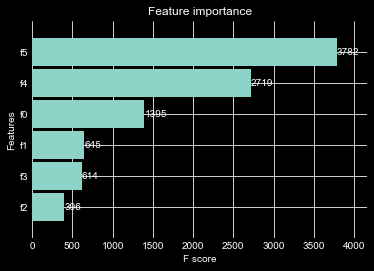

In [91]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgb_reg, height=0.9)

#### Testing the model

In [92]:
from sklearn.metrics import explained_variance_score
predictions = xgb_reg.predict(X_test.to_numpy())

In [93]:
# To get rid of +e format
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [94]:
pred_df = pd.DataFrame({'Actual':y_test['Confirmed'], 'Pred':predictions}) 
pred_df

,Actual,Pred
Country,,
Afghanistan,"1,351","1,443"
Afghanistan,"1,463","1,496"
Albania,678,697
Albania,712,713
Algeria,"3,127","3,253"
...,...,...
Zambia,84,91
Zimbabwe,29,33
Zimbabwe,31,34


In [95]:
pred_df.to_csv("pred_df.csv")

In [96]:
pred_df_with_wrong_preds = pred_df.iloc[0:0,:].copy()
for i in range(0,pred_df.shape[0]):
    if(pred_df['Actual'][i] != pred_df['Pred'][i]):
        pred_df_with_wrong_preds.loc[i,'Actual']=pred_df['Actual'][i]
        pred_df_with_wrong_preds.loc[i,'Pred']=pred_df['Pred'][i]
pred_df_with_wrong_preds   

,Actual,Pred
Country,,
0,"1,351","1,443"
1,"1,463","1,496"
2,678,697
3,712,713
4,"3,127","3,253"
...,...,...
399,84,91
400,29,33
401,31,34


#### Evaluation results

In [97]:
print("MAE train: ", metrics.mean_absolute_error(y_train, xgb_reg.predict(X_train.to_numpy()))) 
print("MSE train: ",metrics.mean_squared_error(y_train, xgb_reg.predict(X_train.to_numpy())))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, xgb_reg.predict(X_train.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, xgb_reg.predict(X_train.to_numpy()))))

print("MAE test: ", metrics.mean_absolute_error(y_test, xgb_reg.predict(X_test.to_numpy()))) 
print("MSE test: ",metrics.mean_squared_error(y_test, xgb_reg.predict(X_test.to_numpy())))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, xgb_reg.predict(X_test.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_test, xgb_reg.predict(X_test.to_numpy()))))

MAE train:  31.41508585373664
MSE train:  25021.646716385476
RMSE train:  158.1823211246613
r2:  0.9999865764206479
MAE test:  1332.486013487424
MSE test:  125262973.29855804
RMSE test:  11192.094232026375
r2:  0.9873960185044578


## XGBoost Regression -  For different countries

In [65]:
import plotly.io as pio

In [66]:
plt.style.use('dark_background')

### Using Kaggle dataset to cross check the results of future prediction 

In [67]:
covid_df_kaggle= pd.read_csv("covid_19_data_Kaggle.csv")

In [68]:
covid_df_kaggle["ObservationDate"]=pd.to_datetime(covid_df_kaggle["ObservationDate"])

In [69]:
covid_df_kaggle.shape

(20574, 8)

### XGBoost Regression - France

In [71]:
covid_df_kaggle_France = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "France"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [75]:
covid_df_kaggle_France_plt = covid_df_kaggle_France[covid_df_kaggle_France['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [77]:
covid_df_kaggle_France_plt.tail()

,ObservationDate,Confirmed,Deaths,Recovered
93,2020-04-26,"162,220","22,890","45,681"
94,2020-04-27,"165,963","23,327","46,293"
95,2020-04-28,"169,053","23,694","47,775"
96,2020-04-29,"166,543","24,121","49,118"
97,2020-04-30,"167,299","24,410","50,380"


In [99]:
filter_condn = (covid_df_kaggle_France['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_France['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_France = covid_df_kaggle_France[filter_condn].reset_index(drop=True)
covid_df_kaggle_France

X_France_df = X[X.index == "France"].copy()
X_France_test = X_France_df.head().copy()
X_France_test=X_France_test.reset_index(drop=True)
X_France_test['days_since_first'] = X_France_test['previous_Confirmed']  = 0
X_France_test.loc[0,'days_since_first'] =  X_France_df["days_since_first"].iloc[-1]+1
#X_France_test.loc[0,'increase_rate']=X_France_df["increase_rate"].iloc[-1]+1
X_France_test.loc[0,'previous_Confirmed'] = y[y.index == "France"].max()[0]

#X_France_test['increase_rate']=X_France_df["increase_rate"].max()


for i in range(0,5):
    X_France_test.loc[i,'days_since_first'] = X_France_test.loc[0,'days_since_first'] + i

X_France_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_France_test.iloc[i]))
    X_France_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_France_test['predicted_infections']= pred.iloc[:, 0] 

X_France_test["ObservationDate"] = covid_df_kaggle_France["ObservationDate"]
covid_df_kaggle_France_plt["predicted_infections"] = covid_df_kaggle_France_plt["Confirmed"] 

covid_df_kaggle_France_plt.iloc[-5,4] = X_France_test.loc[0,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-4,4] = X_France_test.loc[1,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-3,4] = X_France_test.loc[2,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-2,4] = X_France_test.loc[3,'predicted_infections']
covid_df_kaggle_France_plt.iloc[-1,4] = X_France_test.loc[4,'predicted_infections']
    

X_France_test=X_France_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_France_test["Actual infections"] = covid_df_kaggle_France["Confirmed"]
X_France_test["Date"] = covid_df_kaggle_France["ObservationDate"]
X_France_test = X_France_test.iloc[0:5]
X_France_test  

,predicted_infections,Actual infections,Date
0,"168,133","162,220",2020-04-26
1,"170,487","165,963",2020-04-27
2,"172,434","169,053",2020-04-28
3,"175,045","166,543",2020-04-29
4,"178,326","167,299",2020-04-30


(array([737456.00, 737470.00, 737485.00, 737499.00, 737516.00, 737530.00,
        737546.00]),
 <a list of 7 Text major ticklabel objects>)

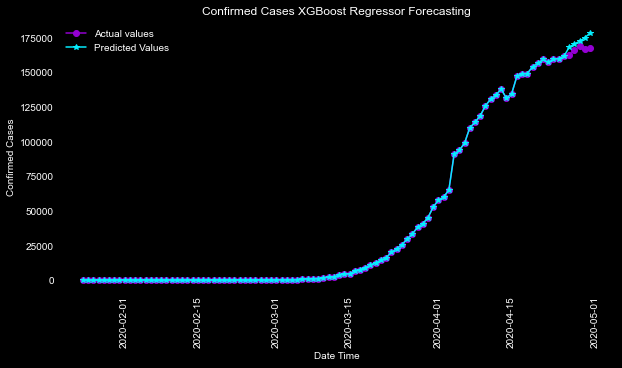

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_France_plt["ObservationDate"],covid_df_kaggle_France_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases XGBoost Regressor Forecasting")
plt.xticks(rotation=90)

### XGBoost Regression - Spain

In [116]:
covid_df_kaggle_Spain = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [117]:
covid_df_kaggle_Spain_plt = covid_df_kaggle_Spain[covid_df_kaggle_Spain['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [118]:
covid_df_kaggle_Spain_plt.tail()

,ObservationDate,Confirmed,Deaths,Recovered
85,2020-04-26,"226,629","23,190","117,727"
86,2020-04-27,"229,422","23,521","120,832"
87,2020-04-28,"232,128","23,822","123,903"
88,2020-04-29,"236,899","24,275","132,929"
89,2020-04-30,"213,435","24,543","112,050"


In [119]:
filter_condn = (covid_df_kaggle_Spain['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Spain['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Spain = covid_df_kaggle_Spain[filter_condn].reset_index(drop=True)
covid_df_kaggle_Spain

X_Spain_df = X[X.index == "Spain"].copy()
X_Spain_test = X_Spain_df.head().copy()
X_Spain_test=X_Spain_test.reset_index(drop=True)
X_Spain_test['days_since_first'] = X_Spain_test['previous_Confirmed']  = 0
X_Spain_test.loc[0,'days_since_first'] =  X_Spain_df["days_since_first"].iloc[-1]+1
#X_Spain_test.loc[0,'increase_rate']=X_Spain_df["increase_rate"].iloc[-1]+1
X_Spain_test.loc[0,'previous_Confirmed'] = y[y.index == "Spain"].max()[0]

#X_Spain_test['increase_rate']=X_Spain_df["increase_rate"].max()


for i in range(0,5):
    X_Spain_test.loc[i,'days_since_first'] = X_Spain_test.loc[0,'days_since_first'] + i

X_Spain_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Spain_test.iloc[i]))
    X_Spain_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Spain_test['predicted_infections']= pred.iloc[:, 0] 

X_Spain_test["ObservationDate"] = covid_df_kaggle_Spain["ObservationDate"]
covid_df_kaggle_Spain_plt["predicted_infections"] = covid_df_kaggle_Spain_plt["Confirmed"] 

covid_df_kaggle_Spain_plt.iloc[-5,4] = X_Spain_test.loc[0,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-4,4] = X_Spain_test.loc[1,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-3,4] = X_Spain_test.loc[2,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-2,4] = X_Spain_test.loc[3,'predicted_infections']
covid_df_kaggle_Spain_plt.iloc[-1,4] = X_Spain_test.loc[4,'predicted_infections']
    

X_Spain_test=X_Spain_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Spain_test["Actual infections"] = covid_df_kaggle_Spain["Confirmed"]
X_Spain_test["Date"] = covid_df_kaggle_Spain["ObservationDate"]
X_Spain_test = X_Spain_test.iloc[0:5]
X_Spain_test  

,predicted_infections,Actual infections,Date
0,"378,761","226,629",2020-04-26
1,"658,156","229,422",2020-04-27
2,"727,323","232,128",2020-04-28
3,"756,689","236,899",2020-04-29
4,"780,098","213,435",2020-04-30


(array([737456.00, 737470.00, 737485.00, 737499.00, 737516.00, 737530.00,
        737546.00]),
 <a list of 7 Text major ticklabel objects>)

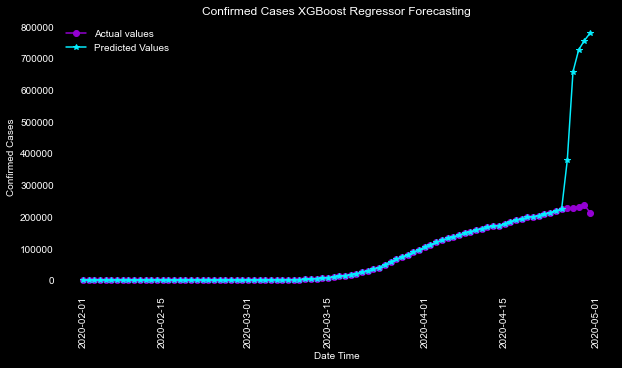

In [120]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Spain_plt["ObservationDate"],covid_df_kaggle_Spain_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases XGBoost Regressor Forecasting")
plt.xticks(rotation=90)

### XGBoost Regression - Germany

In [111]:
covid_df_kaggle_Germany = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Germany"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [112]:
covid_df_kaggle_Germany_plt = covid_df_kaggle_Germany[covid_df_kaggle_Germany['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [113]:
covid_df_kaggle_Germany_plt.tail()

,ObservationDate,Confirmed,Deaths,Recovered
89,2020-04-26,"157,770","5,976","112,000"
90,2020-04-27,"158,758","6,126","114,500"
91,2020-04-28,"159,912","6,314","117,400"
92,2020-04-29,"161,539","6,467","120,400"
93,2020-04-30,"163,009","6,623","123,500"


In [114]:
filter_condn = (covid_df_kaggle_Germany['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Germany['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Germany = covid_df_kaggle_Germany[filter_condn].reset_index(drop=True)
covid_df_kaggle_Germany

X_Germany_df = X[X.index == "Germany"].copy()
X_Germany_test = X_Germany_df.head().copy()
X_Germany_test=X_Germany_test.reset_index(drop=True)
X_Germany_test['days_since_first'] = X_Germany_test['previous_Confirmed']  = 0
X_Germany_test.loc[0,'days_since_first'] =  X_Germany_df["days_since_first"].iloc[-1]+1
#X_Germany_test.loc[0,'increase_rate']=X_Germany_df["increase_rate"].iloc[-1]+1
X_Germany_test.loc[0,'previous_Confirmed'] = y[y.index == "Germany"].max()[0]

#X_Germany_test['increase_rate']=X_Germany_df["increase_rate"].max()


for i in range(0,5):
    X_Germany_test.loc[i,'days_since_first'] = X_Germany_test.loc[0,'days_since_first'] + i

X_Germany_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Germany_test.iloc[i]))
    X_Germany_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Germany_test['predicted_infections']= pred.iloc[:, 0] 

X_Germany_test["ObservationDate"] = covid_df_kaggle_Germany["ObservationDate"]
covid_df_kaggle_Germany_plt["predicted_infections"] = covid_df_kaggle_Germany_plt["Confirmed"] 

covid_df_kaggle_Germany_plt.iloc[-5,4] = X_Germany_test.loc[0,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-4,4] = X_Germany_test.loc[1,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-3,4] = X_Germany_test.loc[2,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-2,4] = X_Germany_test.loc[3,'predicted_infections']
covid_df_kaggle_Germany_plt.iloc[-1,4] = X_Germany_test.loc[4,'predicted_infections']
    

X_Germany_test=X_Germany_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Germany_test["Actual infections"] = covid_df_kaggle_Germany["Confirmed"]
X_Germany_test["Date"] = covid_df_kaggle_Germany["ObservationDate"]
X_Germany_test = X_Germany_test.iloc[0:5]
X_Germany_test  

,predicted_infections,Actual infections,Date
0,"158,280","157,770",2020-04-26
1,"160,535","158,758",2020-04-27
2,"159,613","159,912",2020-04-28
3,"160,535","161,539",2020-04-29
4,"159,613","163,009",2020-04-30


(array([737456.00, 737470.00, 737485.00, 737499.00, 737516.00, 737530.00,
        737546.00]),
 <a list of 7 Text major ticklabel objects>)

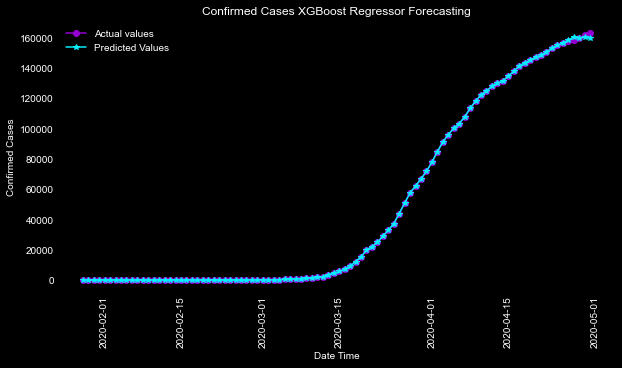

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Germany_plt["ObservationDate"],covid_df_kaggle_Germany_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases XGBoost Regressor Forecasting")
plt.xticks(rotation=90)

### XGBoost Regression - Switzerland

In [106]:
covid_df_kaggle_Switzerland = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Switzerland"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [107]:
covid_df_kaggle_Switzerland_plt = covid_df_kaggle_Switzerland[covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [108]:
covid_df_kaggle_Switzerland_plt.tail()

,ObservationDate,Confirmed,Deaths,Recovered
61,2020-04-26,"29,061","1,610","21,800"
62,2020-04-27,"29,164","1,665","22,200"
63,2020-04-28,"29,264","1,699","22,600"
64,2020-04-29,"29,407","1,716","22,600"
65,2020-04-30,"29,586","1,737","23,400"


In [109]:
filter_condn = (covid_df_kaggle_Switzerland['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Switzerland = covid_df_kaggle_Switzerland[filter_condn].reset_index(drop=True)
covid_df_kaggle_Switzerland

X_Switzerland_df = X[X.index == "Switzerland"].copy()
X_Switzerland_test = X_Switzerland_df.head().copy()
X_Switzerland_test=X_Switzerland_test.reset_index(drop=True)
X_Switzerland_test['days_since_first'] = X_Switzerland_test['previous_Confirmed']  = 0
X_Switzerland_test.loc[0,'days_since_first'] =  X_Switzerland_df["days_since_first"].iloc[-1]+1
#X_Switzerland_test.loc[0,'increase_rate']=X_Switzerland_df["increase_rate"].iloc[-1]+1
X_Switzerland_test.loc[0,'previous_Confirmed'] = y[y.index == "Switzerland"].max()[0]

#X_Switzerland_test['increase_rate']=X_Switzerland_df["increase_rate"].max()


for i in range(0,5):
    X_Switzerland_test.loc[i,'days_since_first'] = X_Switzerland_test.loc[0,'days_since_first'] + i

X_Switzerland_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Switzerland_test.iloc[i]))
    X_Switzerland_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Switzerland_test['predicted_infections']= pred.iloc[:, 0] 

X_Switzerland_test["ObservationDate"] = covid_df_kaggle_Switzerland["ObservationDate"]
covid_df_kaggle_Switzerland_plt["predicted_infections"] = covid_df_kaggle_Switzerland_plt["Confirmed"] 

covid_df_kaggle_Switzerland_plt.iloc[-5,4] = X_Switzerland_test.loc[0,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-4,4] = X_Switzerland_test.loc[1,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-3,4] = X_Switzerland_test.loc[2,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-2,4] = X_Switzerland_test.loc[3,'predicted_infections']
covid_df_kaggle_Switzerland_plt.iloc[-1,4] = X_Switzerland_test.loc[4,'predicted_infections']
    

X_Switzerland_test=X_Switzerland_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Switzerland_test["Actual infections"] = covid_df_kaggle_Switzerland["Confirmed"]
X_Switzerland_test["Date"] = covid_df_kaggle_Switzerland["ObservationDate"]
X_Switzerland_test = X_Switzerland_test.iloc[0:5]
X_Switzerland_test  

,predicted_infections,Actual infections,Date
0,"30,616","29,061",2020-04-26
1,"31,217","29,164",2020-04-27
2,"32,648","29,264",2020-04-28
3,"33,128","29,407",2020-04-29
4,"34,492","29,586",2020-04-30


(array([737485.00, 737499.00, 737516.00, 737530.00, 737546.00]),
 <a list of 5 Text major ticklabel objects>)

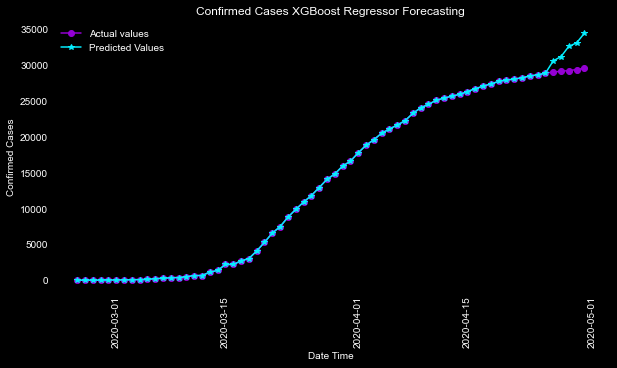

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Switzerland_plt["ObservationDate"],covid_df_kaggle_Switzerland_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Switzerland_plt["ObservationDate"],covid_df_kaggle_Switzerland_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases XGBoost Regressor Forecasting")
plt.xticks(rotation=90)

### XGBoost Regression - Italy

In [101]:
covid_df_kaggle_Italy = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Italy"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Deaths':sum,    # Sum duration per group
                     'Recovered':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()

In [102]:
covid_df_kaggle_Italy_plt = covid_df_kaggle_Italy[covid_df_kaggle_Italy['ObservationDate'] <= '2020-04-30'].reset_index(drop=True)

In [103]:
covid_df_kaggle_Italy_plt.tail()

,ObservationDate,Confirmed,Deaths,Recovered
86,2020-04-26,"197,675","26,644","64,928"
87,2020-04-27,"199,414","26,977","66,624"
88,2020-04-28,"201,505","27,359","68,941"
89,2020-04-29,"203,591","27,682","71,252"
90,2020-04-30,"205,463","27,967","75,945"


In [104]:
filter_condn = (covid_df_kaggle_Italy['ObservationDate'] > '2020-04-25') & (covid_df_kaggle_Italy['ObservationDate'] <= '2020-04-30')
covid_df_kaggle_Italy = covid_df_kaggle_Italy[filter_condn].reset_index(drop=True)
covid_df_kaggle_Italy

X_Italy_df = X[X.index == "Italy"].copy()
X_Italy_test = X_Italy_df.head().copy()
X_Italy_test=X_Italy_test.reset_index(drop=True)
X_Italy_test['days_since_first'] = X_Italy_test['previous_Confirmed']  = 0
X_Italy_test.loc[0,'days_since_first'] =  X_Italy_df["days_since_first"].iloc[-1]+1
#X_Italy_test.loc[0,'increase_rate']=X_Italy_df["increase_rate"].iloc[-1]+1
X_Italy_test.loc[0,'previous_Confirmed'] = y[y.index == "Italy"].max()[0]

#X_Italy_test['increase_rate']=X_Italy_df["increase_rate"].max()


for i in range(0,5):
    X_Italy_test.loc[i,'days_since_first'] = X_Italy_test.loc[0,'days_since_first'] + i

X_Italy_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Italy_test.iloc[i]))
    X_Italy_test.loc[i+1,'previous_Confirmed']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Italy_test['predicted_infections']= pred.iloc[:, 0] 

X_Italy_test["ObservationDate"] = covid_df_kaggle_Italy["ObservationDate"]
covid_df_kaggle_Italy_plt["predicted_infections"] = covid_df_kaggle_Italy_plt["Confirmed"] 

covid_df_kaggle_Italy_plt.iloc[-5,4] = X_Italy_test.loc[0,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-4,4] = X_Italy_test.loc[1,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-3,4] = X_Italy_test.loc[2,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-2,4] = X_Italy_test.loc[3,'predicted_infections']
covid_df_kaggle_Italy_plt.iloc[-1,4] = X_Italy_test.loc[4,'predicted_infections']
    

X_Italy_test=X_Italy_test[{'predicted_infections'}]
# Creating new column to have actual predictions and date from Kaggle dataset
X_Italy_test["Actual infections"] = covid_df_kaggle_Italy["Confirmed"]
X_Italy_test["Date"] = covid_df_kaggle_Italy["ObservationDate"]
X_Italy_test = X_Italy_test.iloc[0:5]
X_Italy_test  

,predicted_infections,Actual infections,Date
0,"209,927","197,675",2020-04-26
1,"337,184","199,414",2020-04-27
2,"607,492","201,505",2020-04-28
3,"757,159","203,591",2020-04-29
4,"781,211","205,463",2020-04-30


(array([737456.00, 737470.00, 737485.00, 737499.00, 737516.00, 737530.00,
        737546.00]),
 <a list of 7 Text major ticklabel objects>)

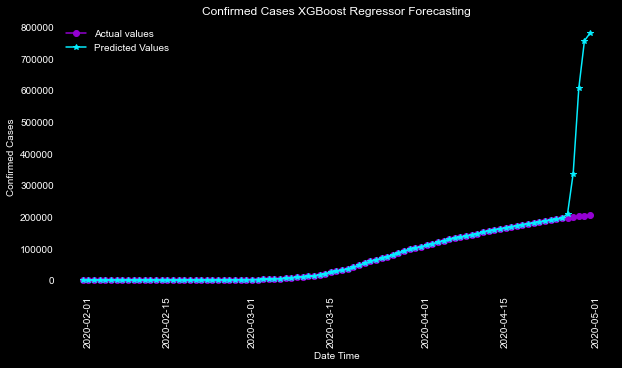

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["Confirmed"],label="Actual values",color = "#9400D3", marker='o')
plt.plot(covid_df_kaggle_Italy_plt["ObservationDate"],covid_df_kaggle_Italy_plt["predicted_infections"],label="Predicted Values", color = "#05eeff", marker='*')
plt.legend()
plt.xlabel("Date Time")
plt.ylabel('Confirmed Cases')
plt.title("Confirmed Cases XGBoost Regressor Forecasting")
plt.xticks(rotation=90)